In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

df = pd.read_csv('merged9.csv')

print(np.shape(df.values[:,:]))

(2734, 114)


In [3]:
data = df.values[:, 10:111].astype(float)
target = df.values[:, 111:113].astype(int)
d_name = np.array(df.columns[10:111])
t_name = np.array(df.columns[111:113])
target1 = target[:,1]

# For Merged9 - Feature 10:111, Target 111:113
# For MergedTop2 - Feature :54 Target 60:62
# For MergedManual1 - Feature 3:43 Target 43:45
# For Merged10 - Feature 4:107, Target 106:109 or 17:109????

In [ ]:
#np.where(d_name == '')
t_name

# Visualization

In [ ]:
# Plot two features
i,j = 1, 0;

plt.figure(figsize=(10,4))
plt.scatter(data[:,i], data[:,j], edgecolor='none', c=target[:,0]); #cmap=cm.brg, alpha=0.5);

cbar = plt.colorbar();
cbar.set_label('Class');
cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10]); 
cbar.set_ticklabels([0,1,2,3,4,5,6,7,8,9,10]);

xlabel(d_name[i]);
ylabel(d_name[j]);
title(d_name[i] + ' vs ' + d_name[j]);

In [ ]:
# Plot three features
from mpl_toolkits.mplot3d import Axes3D
i,j,k = 0, 1, 2

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,i], data[:,j], data[:,k], c=target[:,0])
ax.set_xlabel(d_name[i]);
ax.set_ylabel(d_name[j]);
ax.set_zlabel(d_name[k]);
ax.set_title(d_name[i] + ' vs ' + d_name[j] + ' vs ' + d_name[k], y=1.08)

# Data Processing

(2734, 101)

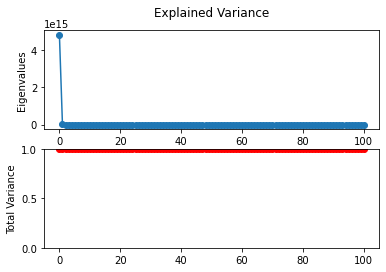

In [4]:
from sklearn.decomposition import PCA

X = data.copy()

pca = PCA(whiten = True);
X_white = pca.fit_transform(X);

# Eigenvalues
E, L = pca.components_.T, pca.explained_variance_
subplot(211);
plot(L,'o-'); 
ylabel('Eigenvalues');
title('Explained Variance', y = 1.08);

# Total Variance
subplot(212); 
cl=np.cumsum(L); 
plot(cl/cl[-1],'o-r'); 
ylabel('Total Variance');
ylim(0,None);

np.shape(X_white)
#plt.savefig('1_explained_variance_lethality2', dpi=200)

In [ ]:
i,j = 0, 1;

plt.figure(figsize=(6,4))
plt.scatter(X_white[:,i], X_white[:,j], edgecolor='none', c=target[:,0]) #cmap=cm.brg, alpha=0.5);

cbar = plt.colorbar();
cbar.set_label('Class');
cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10]); 
cbar.set_ticklabels([0,1,2,3,4,5,6,7,8,9,10]);

# Classifier Testing

In [5]:
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

D = np.hstack((X_white, target1[:,newaxis]))
#D = np.hstack((data, target1[:,newaxis]))
Dc = D.copy()

np.random.seed(seed=2019)
np.random.shuffle(Dc)
seed = 2019

X, C = Dc[:, :101], Dc[:, 101]

In [6]:
unique(C)

array([-6., -5., -4., -3., -2., -1.])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, C)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
figure()
xlabel("Number of features selected")
ylabel("Cross validation score")
plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
title("Number of Features Included versus Accuracy")
#savefig("0_Feature_Selection", dpi=200)

In [ ]:
#k-NN
score_kNN = [];

for k in range(1,50):
    #clf = neighbors.KNeighborsClassifier(k, weights='distance')
    clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    score_kNN.append(np.mean(cross_val_score(clf, X, C, cv=3)))

best = np.max(score_kNN)
k = np.argmax(score_kNN) + 1

print('Best k-NN classifier:', best , 'for', k)

In [ ]:
#Class Priors
classes = np.unique(C).astype(int)
prior = np.ones((2, classes.size))
prior[0] = prior[0] / classes.size;

for k in classes:
    members = (C == k)
    num = members.sum()
    prior[1,k+8] = num / C.size

In [ ]:
#Gaussian NaiveBayes
score_gnb = [];

for p in prior:
    gnb = GaussianNB(priors=p)
    score_gnb.append(np.mean(cross_val_score(gnb, X, C, cv=3)))

best = np.max(score_gnb)
k = np.argmax(score_gnb)

print('Best gnb classifier:', best, 'for', prior[k])

In [ ]:
#LDA
score_lda = [];

for p in prior:
    lda = LDA(priors=p)
    score_lda.append(np.mean(cross_val_score(lda, X, C, cv=3)))

best = np.max(score_lda)
k = np.argmax(score_lda)

print('Best LDA classifier:', best, 'for', prior[k])

In [ ]:
#QDA
score_qda = [];

for p in prior:
    
    qda = QDA(priors=p)
    score_qda.append(np.mean(cross_val_score(qda, X, C, cv=3)))

best = np.max(score_qda)
k = np.argmax(score_qda)

print('Best QDA classifier:', best, 'for', prior[k])

In [ ]:
#Decision Tree
score_tree = [];

for depth in range(1,50):
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=seed)
    score_tree.append(np.mean(cross_val_score(clf, X,C, cv=3)))

best = np.max(score_tree)
k = np.argmax(score_tree) + 1

print('Best tree classifier:', best, 'for', k)

In [ ]:
#Random Forest
score_RF = [];

for depth in range(1,20):
    clf = RandomForestClassifier(max_depth=depth, random_state=seed)
    score_RF.append(np.mean(cross_val_score(clf, X, C, cv=3)))
    
best = np.max(score_RF)
k = np.argmax(score_RF) + 1

print('Best random forest classifier:', best, 'for', k)

In [7]:
#SVM

svc = SVC(kernel='linear')
best = np.mean(cross_val_score(svc, X, C, cv=3))
               
print('Best SVM classifier:', best)

Best SVM classifier: 0.5212188906220913


In [ ]:
#Neural Network
score_NN = [];

for k in range(200,2000,600):
    clf = MLPClassifier(hidden_layer_sizes=(100,), activation='identity', solver='lbfgs', max_iter=k, random_state=seed)
    score_NN.append(np.mean(cross_val_score(clf, X, C, cv=3)))

best = np.max(score_NN)
k = np.argmax(score_NN) * 600 + 200

print('Best Neural Network:', best, 'for', k)

In [ ]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=3,random_state=seed)
print(np.mean(cross_val_score(clf, X, C, cv=3)))

In [ ]:
#XGBoost
import xgboost as xgb
score_xgb = [];

for k in range(0,1):
    clf = xgb.XGBClassifier(eta=0.1, max_depth=4, min_child_weight=8, 
                            gamma=0, subsample=1, colsample_bytree=0.1, alpha=0,
                            n_estimators=83)
    #(eta=0.01, max_depth=k, min_child_weight=2, gamma=0, subsample=0.2, colsample_bytree=0.2, alpha=0)
    score_xgb.append(np.mean(cross_val_score(clf, X, C, cv=3)))

best = np.max(score_xgb)
k = np.argmax(score_xgb) 

print('Best XGBoost:', best, 'for', k)
# 0.5969348659003831

In [ ]:
from sklearn import metrics   #Additional scklearn functions
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 4

In [ ]:
xgb1 = xgb.XGBClassifier(eta=0.1, max_depth=2, min_child_weight=2, gamma=0)

xgb1.fit(data, target1)                   

feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
print("Accuracy : %.4g" % metrics.accuracy_score(target1, xgb1.predict(data)))

In [ ]:
d_name[[0,1,6,15,30,49,70,26,7,100,20,3,25,31,47]]

# Solution Visualization


In [ ]:
#Visualization with CV
from sklearn.metrics import confusion_matrix

D = np.hstack((data,target1[:, newaxis])) #((X_white, target1[:, newaxis]))
Dc = D.copy()

np.random.seed(seed=2019)
np.random.shuffle(Dc)

cv = 2
split = int(Dc[:,0].size/cv)
index = (cv-1) * split


X_train, C_train = Dc[:index, :103], Dc[:index, 103]
X_test, C_true = Dc[index:, :103], Dc[index:, 103]

#clf = neighbors.KNeighborsClassifier(31, weights='distance')
#clf = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=seed)
#clf = SVC(kernel='linear')
#clf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', max_iter=800, random_state=seed)
clf = xgb.XGBClassifier(eta=0.1, max_depth=2, min_child_weight=2, gamma=0)
C_pred = clf.fit(X_train, C_train).predict(X_test)


print("Number of mislabeled points out of a total %3d points : %2d" \
        % (X_test.shape[0],(C_true!=C_pred).sum()))

#Visualizing using a Color Map
CM = confusion_matrix(C_true, C_pred, labels=[-6,-5,-4,-3,-2,-1]); 
#l = ['-','-10', '-9', '-8', '-7', '-6', '-5','-4','-3']; #[-10,-9,-8,-7,-6,-5,-4,-3]
#l = ['-','-12','-11','-10', '-9', '-8', '-7','-6']; #[-12,-11,-10,-9,-8,-7,-6]
l = ['-','-6','-5','-4','-3','-2','-1']; #[-6,-5,-4,-3,-2,-1]

fig, ax = plt.subplots(figsize=(15, 9))
ax.matshow(CM, cmap=plt.cm.Blues)
ax.set(title='Confusion Matrix on COVID-19 Lethality \n', ylabel='True class label', xlabel='Predicted class label');
ax.xaxis.set_ticklabels(l); ax.yaxis.set_ticklabels(l);
ax.xaxis.set_label_position('top'); ax.xaxis.tick_top();
for i in range(6):
    for j in range(6):
        c = CM[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

#savefig('2_CM_lethality2', dpi=200);

In [1]:
# Visualization using plot
i, j = 1, 0;
figure(figsize = (25,5))
suptitle('Neural Network on COVID-19 Severity')
subplot(121) # plot points colored according to the true class lebels
scatter(X_test[:, i], X_test[:, j], c = C_true, cmap = cm.rainbow, s = 50, edgecolor = 'k');
xlabel(d_name[i]);
ylabel(d_name[j]);
#xlabel('1st Principal Component');
#ylabel('2nd Principal Component');
title('True Class Label');
subplot(122) # plot points colored according to the predicted class lebels
scatter(X_test[:, i], X_test[:, j], c = C_pred, cmap = cm.rainbow, s = 50, edgecolor = 'k');
xlabel(d_name[i]);
ylabel(d_name[j]);
#xlabel('1st Principal Component');
#ylabel('2nd Principal Component');
title('Predicted Class Label');

#colorbar();
#savefig('3_Plot_severity', dpi=200);

NameError: name 'figure' is not defined